Ноутбук для анализа данных

## Загрузка данных

### Иморты

In [1]:
import json
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.style.use('ggplot')

from wordcloud import WordCloud, STOPWORDS

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN
from umap import UMAP

c:\D drive\Biocad\biocad-ml-internship\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 1000x600 with 0 Axes>

### Загрузка

In [2]:
df = pd.read_json('../data/alzheimer_articles.json')
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   pmid          100 non-null    int64
 1   title         100 non-null    str  
 2   abstract      100 non-null    str  
 3   year          100 non-null    int64
 4   url           100 non-null    str  
 5   introduction  100 non-null    str  
 6   conclusion    100 non-null    str  
dtypes: int64(2), str(5)
memory usage: 5.6 KB


In [3]:
df.head()

,pmid,title,abstract,year,url,introduction,conclusion
0,35558075,Microglia in the Neuroinflammatory Pathogenesi...,Alzheimer's disease (AD) is the most prevalent...,2022,https://pubmed.ncbi.nlm.nih.gov/35558075/,Alzheimer’s disease (AD) is the most common ne...,"In summary, microglia are crucial mediator and..."
1,39537608,Multi-trait association analysis reveals share...,Several cardiovascular traits and diseases co-...,2024,https://pubmed.ncbi.nlm.nih.gov/39537608/,"Alzheimer’s disease (AD), the most common caus...",We adopted a comprehensive approach to underst...
2,37349091,Systematic druggable genome-wide Mendelian ran...,BACKGROUND: Alzheimer's disease (AD) is the le...,2023,https://pubmed.ncbi.nlm.nih.gov/37349091/,Alzheimer’s disease (AD) is the most common ne...,The development of novel therapeutic agents fo...
3,39031970,The neuroinflammatory role of microglia in Alz...,"INTRODUCTION: Alzheimer's disease (AD), the ma...",2024,https://pubmed.ncbi.nlm.nih.gov/39031970/,Alzheimer's disease (AD); a toxic neurodegener...,Chronic inflammation is currently considered t...
4,40247363,TREM2 and sTREM2 in Alzheimer's disease: from ...,Triggering receptor expressed on myeloid cells...,2025,https://pubmed.ncbi.nlm.nih.gov/40247363/,Alzheimer’s disease (AD) is a devastating neur...,"TREM2, both as a cell-surface receptor and in ..."


Данные целые, пропусков нет

## Анализ данных

### Длины текстов

In [4]:
# Статистический анализ текстовых данных
df_describe = df.copy().drop(columns=['pmid', 'year', 'title', 'abstract', 'introduction', 'conclusion'])
df_describe['title'] = df['title'].str.len()
df_describe['abstract'] = df['abstract'].str.len()
df_describe['introduction'] = df['introduction'].fillna('').str.len()
df_describe['conclusion'] = df['conclusion'].fillna('').str.len()
df_describe.describe()

,title,abstract,introduction,conclusion
count,100.000000,100.000000,100.000000,100.000000
mean,96.000000,1353.570000,3817.710000,4449.280000
std,27.357343,392.931645,1779.254544,4061.234126
min,43.000000,657.000000,1185.000000,272.000000
25%,72.750000,1093.250000,2526.500000,1591.750000
50%,95.500000,1261.000000,3581.500000,2893.000000
75%,115.000000,1519.750000,4693.000000,6109.750000
max,163.000000,2706.000000,12439.000000,17597.000000


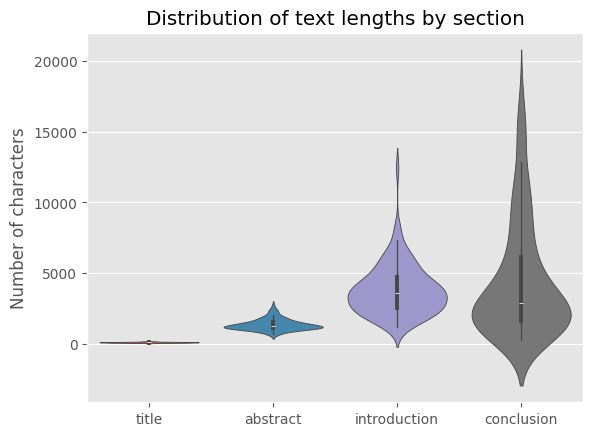

In [5]:
sns.violinplot(data=df_describe[[
    'title',
    'abstract',
    'introduction',
    'conclusion'
    ]],
)

plt.ylabel('Number of characters')
plt.title('Distribution of text lengths by section')
plt.show()

Распределение длин текстов показало, что в данных есть выбросы в Введении и Выводах, скорее всего это обзорные статьи. 

Проверим, что длинные статьи содержательны.

In [6]:
df[df['conclusion'].str.len() > 15000]

,pmid,title,abstract,year,url,introduction,conclusion
14,40050982,Biomarker identification for Alzheimer's disea...,BACKGROUND: Alzheimer's disease (AD) is the ma...,2025,https://pubmed.ncbi.nlm.nih.gov/40050982/,Alzheimer’s disease (AD) is a progressive neur...,"In this study, our comprehensive pipeline incl..."
46,40310500,Role of Ion Channels in Alzheimer's Disease Pa...,Ion channels play an integral role in the norm...,2025,https://pubmed.ncbi.nlm.nih.gov/40310500/,Alzheimer’s disease (AD) is a progressive neur...,"In this review, we outline the roles that diff..."
74,38915415,Unveiling Immune-related feature genes for Alz...,The identification of diagnostic and therapeut...,2024,https://pubmed.ncbi.nlm.nih.gov/38915415/,Alzheimer’s disease (AD) is the most common fo...,"AD, a chronic neurodegenerative disease and th..."


Выбросы являются полноценными статьями

### Анализ по годам

Text(0.5, 1.0, 'Number of articles by year')

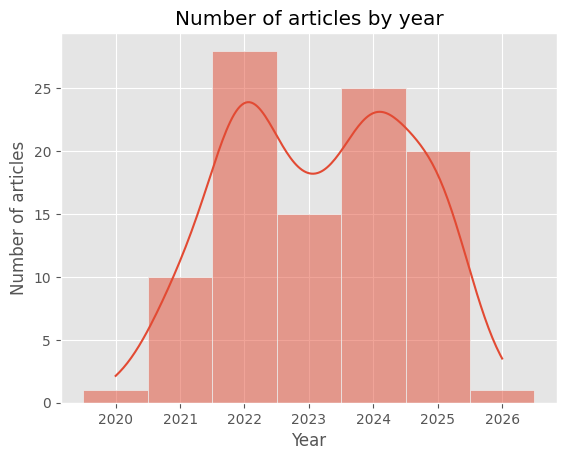

In [7]:
sns.histplot(
    data=df,
    x='year',
    kde=True,
    bins=5,
    discrete=True,
)

plt.xlabel('Year')
plt.ylabel('Number of articles')
plt.title('Number of articles by year')

При сборе данных использовалась сортировка по релевантным статьям. Благодаря этому были отобраны наиболее свежие статьи (за последние 5 лет).

Небольшой спад в 2023 году может быть связан как с особенностями выборки, так и с циклами научных публикаций.


### Облако ключевых слов

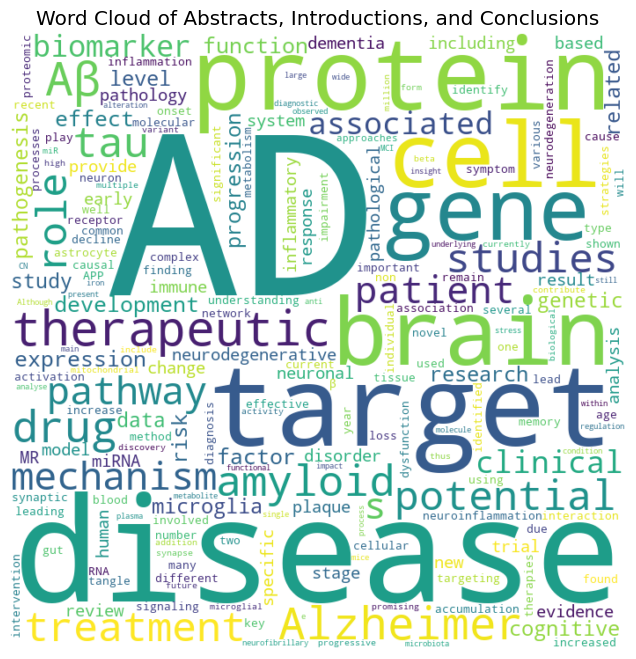

In [8]:
# Создаем общий текст из всех абстрактов, введений и заключений
total_text = ' '.join(df['abstract'].fillna('').tolist()) +\
    ' '.join(df['introduction'].fillna('').tolist()) +\
    ' '.join(df['conclusion'].fillna('').tolist())

# Добавляем свои частые стоп-слова из статей
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["et", "al", "fig", "figure", "table", "may", "suggest"])

# Создаем и отображаем облако слов
wordcloud = WordCloud(
    width=700,
    height=700,
    background_color='white',
    stopwords=custom_stopwords,
    collocations=False
).generate(total_text)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Abstracts, Introductions, and Conclusions')
plt.show()

В тексте преобладают тематические слова и термины, что говорит о чистоте данных. Но пока не понятно насколько данные содержательны. Для проверки использую BERTopic

In [9]:
# Объединяем тексты
bert_df = df['abstract'].fillna('') + ' ' + \
          df['introduction'].fillna('') + ' ' + \
          df['conclusion'].fillna('')

# Настраиваем UMAP для малых данных
umap_model = UMAP(n_neighbors=3, 
                  n_components=5, 
                  min_dist=0.0, 
                  metric='cosine', 
                  random_state=42)

# Настраиваем HDBSCAN для малых данных
hdbscan_model = HDBSCAN(min_cluster_size=2, 
                        metric='euclidean', 
                        cluster_selection_method='eom', 
                        prediction_data=True)

# Убираем стоп-слова
vectorizer_model = CountVectorizer(stop_words="english")

# Настраиваем BERTopic
model = BERTopic(
    embedding_model="all-mpnet-base-v2",
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    language="english",
    verbose=True,
    nr_topics="auto"
)

# Обучение
topics, probs = model.fit_transform(bert_df.tolist())

# Смотрим результат
freq = model.get_topic_info()
print(f"Найдено тем: {len(freq) - 1}") # тема -1, тк это шум
display(freq.head(10))

2026-02-08 02:21:55,819 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 4/4 [00:36<00:00,  9.10s/it]
2026-02-08 02:22:38,241 - BERTopic - Embedding - Completed ✓
2026-02-08 02:22:38,242 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-02-08 02:22:45,427 - BERTopic - Dimensionality - Completed ✓
2026-02-08 02:22:45,428 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-02-08 02:22:45,435 - BERTopic - Cluster - Completed ✓
2026-02-08 02:22:45,436 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2026-02-08 02:22:45,531 - BERTopic - Representation - Completed ✓
2026-02-08 02:22:45,532 - BERTopic - Topic reduction - Reducing number of topics
2026-02-08 02:22:45,539 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-02-08 02:22:45,630 - BERTopic - Representation - Completed ✓
2026-02-08 02:22:45,632 - BERTopic - Topic reduction - Reduce

Найдено тем: 5


,Topic,Count,Name,Representation,Representative_Docs
0,-1,7,-1_et_al_lysosomal_microglia,"[et, al, lysosomal, microglia, ad, iron, sorla...","[Alzheimer's disease (AD) is a progressive, ne..."
1,0,52,0_ad_disease_et_al,"[ad, disease, et, al, aβ, amyloid, brain, tau,...",[Damage or loss of brain cells and impaired ne...
2,1,25,1_ad_genes_disease_mr,"[ad, genes, disease, mr, targets, data, study,...",[BACKGROUND: Alzheimer's disease (AD) is the l...
3,2,8,2_mirnas_mir_ad_43,"[mirnas, mir, ad, 43, tdp, disease, therapeuti...",[Identifying target microRNAs (miRNAs) might s...
4,3,5,3_gut_microbiota_ad_metabolites,"[gut, microbiota, ad, metabolites, bacteria, h...",[Shifts in the magnitude and nature of gut mic...
5,4,3,4_cell_single_ad_astrocytes,"[cell, single, ad, astrocytes, spatial, sequen...",[Alzheimer's disease (AD) is a progressive neu...


In [10]:
model.visualize_topics()

In [11]:
model.visualize_heatmap()


Анализ через BERTopic показал наличие 6 тем, некотоорые из них взаимосвязаны: 

(0) "aβ амилоидные бляшки" и (2) "влияние микробиоты" (что вполне логично из-за метаболизма и теории возникновения бляшек); 

(4) "мкРНК" и (3) "глубокие механизмы регуляции" (эпигинетика процессов);

Отедльные темы (1) про "генетические риски" и (5) про исследования с помощью scRNA-seq.

В датасете есть как статьи по фундаметальным темам (0), так и узкоспециализированные ниши (2) и (4). 

В дальнейшем это позволяет агенту отвечать на различные темы, а не фокусироваться на мейнстриме. Но из-за ограниченных данных (всего 100 статей и 6 топиков), ландшафт данных всё равно будет ограничивать тематические возможности агента.